In [108]:
import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")
import numpy as np
import awkward as ak
from glob import glob
from tqdm.notebook import tqdm

In [93]:
fs = glob("/Users/jlazar/Downloads/MuMinus_Hadrons_seed_750*_meta_data_noisy_smt.parquet")
other_fs = glob("/Users/jlazar/Downloads/MuMinus_Hadrons_seed_7500*_meta_data.parquet")
events = ak.from_parquet(fs[0])

In [96]:
def qcog(event):
    """Find the charge weighted center of gravity of an event"""
    if isinstance(event, ak.highlevel.Array):
        cog = np.array([
            np.mean(event["total", "sensor_pos_x"], axis=1),
            np.mean(event["total", "sensor_pos_y"], axis=1),
            np.mean(event["total", "sensor_pos_z"], axis=1),
        ])
    else:
        xyz = np.array([
            event.total.sensor_pos_x,
            event.total.sensor_pos_y,
            event.total.sensor_pos_z,
        ])
        cog = np.mean(xyz, axis=1)
    return cog
qcog(events[0])

array([ -37.33903242, -284.32294891, -399.77186663])

In [97]:
def nhits(event):
    """find the number of photons that arrived at any OM"""
    if isinstance(event, ak.highlevel.Array):
        return np.array([len(x) for x in event.total.t])
    else:
        return len(event.total.t)
nhits(events[0])

1419

In [98]:
from fit_ellipsoid import fit_ellipsoid
def ellipsoid_ratio(event):
    """Find ratio of semimajor axes of ellipsoid with symmetry about z-axis"""
    if isinstance(event, ak.highlevel.Array):
        ratio = np.array([ellipsoid_ratio(e) for e in tqdm(event, desc="Computing ellipsoids")])
    else:
        
        res = fit_ellipsoid(event)
        ratio = res.x[0] / res.x[1]
    return ratio
ellipsoid_ratio(events[:5])

Computing ellipsoids:   0%|          | 0/5 [00:00<?, ?it/s]

array([0.64667003, 0.45400516, 0.32611123, 0.08606009, 0.11474201])

In [99]:
def passed_quality(event):
    """Determine if event passes our quality filter"""
    if isinstance(event, ak.highlevel.Array):
        m1 = np.argwhere(nhits(event) > 11).flatten()
        m2 = m1[np.argwhere(np.linalg.norm(qcog(event[m1]), axis=0) < 400).flatten()]
        eratio = ellipsoid_ratio(event[m2])
        m3 = m2[np.argwhere(
            np.logical_and(
                2 < eratio,
                eratio < 8
            )
        )]
        mask = np.full(len(event), False)
        mask[m3.flatten()] = True
        return mask
    else:
        if nhits(event) <= 11:
            return False
        if np.linalg.norm(qcog(event)) > 400:
            return False
        eratio = ellipsoid_ratio(event)
        if 2 > eratio or 8 < eratio:
            return False
        return True
passed_quality(events[2:4])

Computing ellipsoids: 0it [00:00, ?it/s]

array([False, False])

In [100]:
# quality_masks = []
# # for f in fs:
# for f in tqdm(fs, desc="Might be a good time to get some coffee"):
#     events = ak.from_parquet(f)
#     quality_mask = passed_quality(events)
#     quality_masks.append(quality_mask)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern, Latin Modern Roman, Bitstream Vera Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern, Latin Modern Roman, Bitstream Vera Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern, Latin Modern Roman, Bitstream Vera Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern, Latin Modern Roman, Bitstream Vera Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern, Latin Modern Roman, Bitstream Vera Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern, Latin Modern Roman, Bitstream Vera Serif
findfont: Generic family 'serif' not found because none of the following families were f

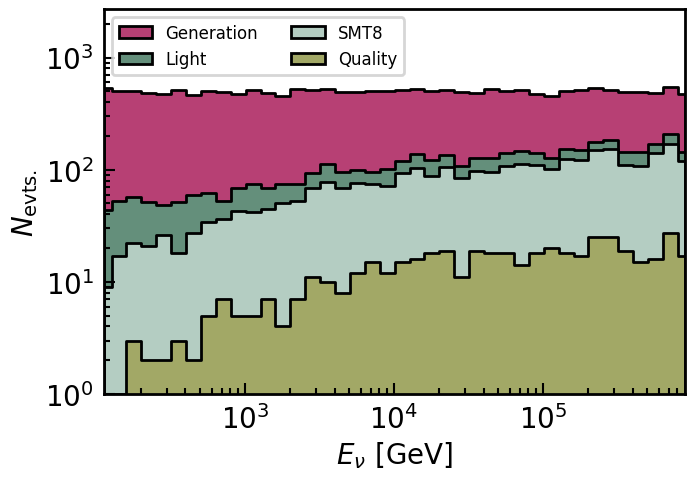

In [110]:
ebins = np.logspace(2, 6, 41)
ecents = (ebins[1:] + ebins[:-1]) / 2
ewidths = ebins[1:] - ebins[:-1]

labels = ["Generation", "Light", "SMT8", "Quality"]

for idx, label in enumerate(labels):
    h = np.zeros(ecents.shape)
    if idx==0 or idx==1:
        itr = enumerate(tqdm(other_fs))
    else:
        itr = enumerate(tqdm(fs))
    for jdx, f in itr:
        a = ak.from_parquet(f)
        if idx==0:
            h_tmp, _ = np.histogram(a.mc_truth.injection_energy, bins=ebins)
        elif idx==1:
            mask = np.array([len(x)>1 for x in a.total.t])
            h_tmp, _ = np.histogram(a.mc_truth.injection_energy[mask], bins=ebins)
        if idx==2:
            h_tmp, _ = np.histogram(a.mc_truth.injection_energy, bins=ebins)
        elif idx==3:
            h_tmp, _ = np.histogram(a.mc_truth.injection_energy[quality_masks[jdx]], bins=ebins)
        h = h + h_tmp
    if idx==0:
        plt.ylim(1, 5*np.max(h))
    plt.fill_between(ecents, 0, h, edgecolor="k", label=label, step="mid")
    # plt.fill_between(ecents, 0, h, edgecolor="k", label=label, facecolor=color, step="mid")
plt.legend(loc=2, fontsize=12, ncol=2)
plt.ylabel(r"$N_{\rm{evts.}}$")
plt.xlabel(r"$E_{\nu}~\left[\rm{GeV}\right]$")
plt.loglog()
plt.xlim(ecents[0], ecents[-1])
plt.ylim(1, None)
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern, Latin Modern Roman, Bitstream Vera Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern, Latin Modern Roman, Bitstream Vera Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern, Latin Modern Roman, Bitstream Vera Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern, Latin Modern Roman, Bitstream Vera Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern, Latin Modern Roman, Bitstream Vera Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern, Latin Modern Roman, Bitstream Vera Serif
findfont: Generic family 'serif' not found because none of the following families were f

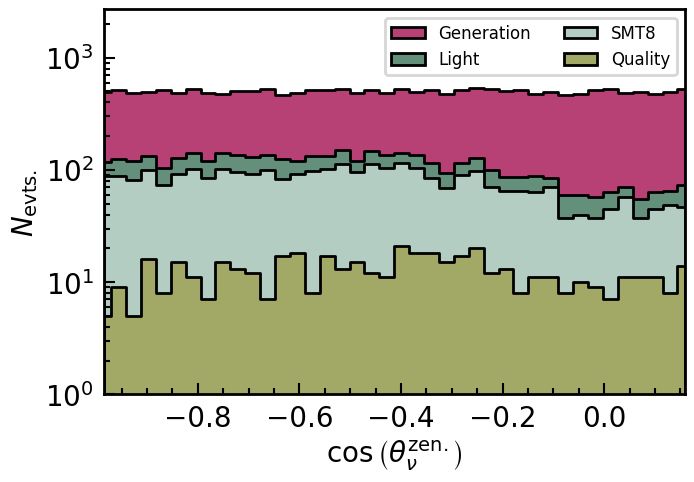

In [113]:
czbins = np.linspace(-1, 0.17364817766693041, 41)
czcents = (czbins[1:] + czbins[:-1]) / 2

labels = ["Generation", "Light", "SMT8", "Quality"]

for idx, label in enumerate(labels):
    h = np.zeros(ecents.shape)
    if idx==0 or idx==1:
        itr = enumerate(tqdm(other_fs))
    else:
        itr = enumerate(tqdm(fs))
    for jdx, f in itr:
        a = ak.from_parquet(f)
        if idx==0:
            h_tmp, _ = np.histogram(np.cos(a.mc_truth.injection_zenith), bins=czbins)
        elif idx==1:
            mask = np.array([len(x)>1 for x in a.total.t])
            h_tmp, _ = np.histogram(np.cos(a.mc_truth.injection_zenith)[mask], bins=czbins)
        elif idx==2:
            h_tmp, _ = np.histogram(np.cos(a.mc_truth.injection_zenith), bins=czbins)
        elif idx==3:
            h_tmp, _ = np.histogram(np.cos(a.mc_truth.injection_zenith)[quality_masks[jdx]], bins=czbins)
        else:
            raise ValueError()
        h = h + h_tmp
    plt.fill_between(czcents, 0, h, edgecolor="k", label=label, step="mid")
    if idx==0:
        plt.ylim(1, 5*np.max(h))
plt.xlabel(r"$\cos\left(\theta_{\nu}^{\rm{zen.}}\right)$")
plt.ylabel(r"$N_{\rm{evts.}}$")
plt.legend(loc=1, fontsize=12, ncol=2)
plt.semilogy()
plt.xlim(czcents[0], czcents[-1])
plt.show()